In [1]:
!pip -q install pandas numpy scikit-learn matplotlib
import io, sys, math, datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import kagglehub
import os, glob

1) Install & import basics

pip install …: Makes sure the tools we need are available (often already installed in Colab).

pandas, numpy: Data handling. Think Excel-in-code (pandas = tables called DataFrames).

matplotlib: For charts.

scikit-learn (sklearn): Popular machine-learning toolbox: models and evaluation.

LinearRegression: A simple prediction model (draws a “best fit” line in many dimensions).

RandomForestRegressor: A stronger model that builds many decision trees and averages them (often more accurate than a single line).

In [2]:
# Download dataset
dataset_path = kagglehub.dataset_download("emrekaany/google-daily-stock-prices-2004-today")
print("Path to dataset files:", dataset_path)

# Detect the CSV file (should be 'googl_daily_prices.csv')
csv_candidates = glob.glob(os.path.join(dataset_path, "*.csv"))
if not csv_candidates:
    raise FileNotFoundError("No CSV file found in dataset folder.")
csv_name = csv_candidates[0]   # keep your variable name 'csv_name'

100%|██████████| 96.2k/96.2k [00:00<00:00, 31.1MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/emrekaany/google-daily-stock-prices-2004-today/versions/163


2) Upload your CSV

files.upload(): Opens a file picker so you can upload your Kaggle CSV.

csv_name: Stores the file name you uploaded so we can read it next.

In [3]:
df = pd.read_csv(csv_name)
# Define the mapping from current column names to desired names
column_mapping = {
    'date': 'Date',
    '1. open': 'Open',
    '2. high': 'High',
    '3. low': 'Low',
    '4. close': 'Close',
    '5. volume': 'Volume'
}
# Rename the columns
df = df.rename(columns=column_mapping)

expected_cols = {'Date','Open','High','Low','Close','Volume'}
#convert Date column data type to datetime
df['Date'] = pd.to_datetime(df['Date'])
#Sort records by date oldest to newest, remove duplicates
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop_duplicates(subset=['Date'], keep='last').reset_index(drop=True)
#Fill missing values
df[['Open','High','Low','Close','Volume']] = df[['Open','High','Low','Close','Volume']].fillna(method='ffill').fillna(method='bfill')
df = df[['Date','Open','High','Low','Close','Volume']]

df.head()

/tmp/ipython-input-4055794331.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[['Open','High','Low','Close','Volume']] = df[['Open','High','Low','Close','Volume']].fillna(method='ffill').fillna(method='bfill')


,Date,Open,High,Low,Close,Volume
0,2004-08-19,100.01,104.06,95.96,100.335,44659000.0
1,2004-08-20,101.01,109.08,100.50,108.310,22834300.0
2,2004-08-23,110.76,113.48,109.05,109.400,18256100.0
3,2004-08-24,111.24,111.60,103.57,104.870,15247300.0
4,2004-08-25,104.76,108.00,103.88,106.000,9188600.0


3. Load clean sort

pd.read_csv(...) loads your CSV into a table (DataFrame).

The column_mapping renames long column names like "1. open" to simpler names like "Open".

pd.to_datetime makes sure the Date column is treated as actual dates, not plain text.

sort_values puts the rows in the correct time order.

drop_duplicates removes duplicate rows for the same date.

fillna(method='ffill') fills empty cells with the last known value (“carry forward”), and bfill fills any leftovers from below. This prevents errors during training.

Finally, we keep just the six columns you care about.

In [4]:
def add_features(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()

    # Percentage price changes (returns)
    d['ret_1d']  = d['Close'].pct_change(1)
    d['ret_5d']  = d['Close'].pct_change(5)
    d['ret_10d'] = d['Close'].pct_change(10)

    # Moving averages (trend)
    d['ma_5']  = d['Close'].rolling(5).mean()
    d['ma_10'] = d['Close'].rolling(10).mean()
    d['ma_20'] = d['Close'].rolling(20).mean()

    # Volatility proxy (how much it wiggles)
    d['vol_10'] = d['ret_1d'].rolling(10).std()

    # Intraday range and volume change
    d['hl_range']   = (d['High'] - d['Low']) / d['Close']
    d['vol_chg_5d'] = d['Volume'].pct_change(5)

    # Target: tomorrow's Close
    d['y_next_close'] = d['Close'].shift(-1)

    # Remove rows with NaNs created by rolling/shift
    d = d.dropna().reset_index(drop=True)
    return d

df_feat = add_features(df)
df_feat.head()


,Date,Open,High,Low,Close,Volume,ret_1d,ret_5d,ret_10d,ma_5,ma_10,ma_20,vol_10,hl_range,vol_chg_5d,y_next_close
0,2004-09-16,112.34,115.80,111.65,113.97,9266300.0,0.017589,0.113967,0.136858,110.058,105.800,105.28025,0.014850,0.036413,1.281385,117.49
1,2004-09-17,114.42,117.49,113.55,117.49,9472500.0,0.030885,0.115447,0.157423,112.490,107.398,106.13800,0.015884,0.033535,0.088943,119.36
2,2004-09-20,116.95,121.60,116.77,119.36,10628700.0,0.015916,0.110326,0.193481,114.862,109.333,106.69050,0.012021,0.040466,0.354993,117.84
3,2004-09-21,120.20,120.42,117.51,117.84,7228700.0,-0.012735,0.056956,0.160071,116.132,110.959,107.11250,0.015469,0.024695,-0.332462,118.38
4,2004-09-22,117.45,119.67,116.81,118.38,7581200.0,0.004582,0.056964,0.157185,117.408,112.567,107.78800,0.015632,0.024159,-0.292336,120.82


4. Create extra features

We’re adding extra information (features) to help the model:

ret_1d: % change from yesterday’s close

ret_5d / ret_10d: % change over 5 and 10 days

ma_5 / ma_10 / ma_20: moving averages to capture trends

vol_10: how much daily prices fluctuate over 10 days (a measure of risk/volatility)

hl_range: the size of daily swings relative to closing price

vol_chg_5d: how trading activity (volume) changes over 5 days

y_next_close: the number we want to predict (the close price of the next day).

In [13]:
def make_window_features(data: pd.DataFrame, n_days: int =7):
    # 14 daily feature columns (5 OHLCV + 9 engineered)
    feature_cols = [
        'Open','High','Low','Close','Volume',
        'ret_1d','ret_5d','ret_10d',
        'ma_5','ma_10','ma_20',
        'vol_10','hl_range','vol_chg_5d'
    ]

    arr   = data[feature_cols].values
    y     = data['y_next_close'].values
    dates = data['Date'].values

    X_list, y_list, date_list = [], [], []
    for i in range(n_days, len(data)):
        window = arr[i-n_days:i, :]         # last n_days of features
        X_list.append(window.flatten())     # make one long row: n_days * 14
        y_list.append(y[i])                 # tomorrow's Close at i
        date_list.append(dates[i])          # date associated with that target

    X = np.array(X_list)
    y = np.array(y_list)
    kept_dates = np.array(date_list)
    return X, y, kept_dates, feature_cols

N_DAYS = 30
X, y, X_dates, feature_cols = make_window_features(df_feat, n_days=N_DAYS)
X.shape, y.shape


((5265, 420), (5265,))

5. Turn past days into inputs

Instead of using just one day’s numbers, we “stack” the last 30 days of values into one big row.

Each row of X now contains 30 days (N_DAYS)  × 14 features = 420 numbers.

y is tomorrow’s closing price, so the model learns: “Given the last 30 days, what’s the next day’s closing price?”

In [14]:
dates = pd.to_datetime(pd.Series(X_dates))

train_mask = dates.dt.year <= 2019      # train on oldest years
val_mask   = (dates.dt.year >= 2020) & (dates.dt.year <= 2022)  # validation, tune here
test_mask  = dates.dt.year >= 2023      # final test on newest years

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]
X_test,  y_test  = X[test_mask],  y[test_mask]

print("Train/Val/Test sizes:", X_train.shape, X_val.shape, X_test.shape)


Train/Val/Test sizes: (3820, 420) (756, 420) (689, 420)


6. Split data into training (oldest - 2019), validation (2020 - 2022), test (2023 - newest). We learn on older data, tune on mid-range data, and test on the most recent data.

In [15]:
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)  # learn scaling on train
X_val_s   = scaler.transform(X_val)        # apply same scaling
X_test_s  = scaler.transform(X_test)


7. Scaling squeezes features into a similar range (≈0–1). This helps linear models learn fairly.

In [21]:
def evaluate(y_true, y_pred, label="set"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = float(np.mean(np.abs((y_true - y_pred)/y_true)) * 100)
    print(f"{label} -> MAE: {mae:.3f} | RMSE: {rmse:.3f} | MAPE: {mape:.2f}%")

# Find the index of the last day's Close inside each flattened window row
n_feats_per_day = len(feature_cols)          # 14
close_idx       = feature_cols.index('Close')
last_close_idx  = (N_DAYS - 1) * n_feats_per_day + close_idx

baseline_val  = X_val[:,  last_close_idx]
baseline_test = X_test[:, last_close_idx]

print("Baseline (tomorrow ≈ today’s Close)")
evaluate(y_val,  baseline_val,  "VAL")
evaluate(y_test, baseline_test, "TEST")


Baseline (tomorrow ≈ today’s Close)
VAL -> MAE: 40.936 | RMSE: 119.982 | MAPE: 7.13%
TEST -> MAE: 3.102 | RMSE: 4.179 | MAPE: 2.05%


8. A dumb but strong baseline: predict tomorrow’s Close as today’s Close (the last day in the window). Our ML models should beat this.
Computes MAE (Mean Absolute Error
), RMSE (Root Mean Squared Error
 ) , MAPE(Mean Absolute Percentage Error
 )

In [17]:
# Linear Regression (use scaled inputs)
lin = LinearRegression()
lin.fit(X_train_s, y_train)
lin_val_pred  = lin.predict(X_val_s)
lin_test_pred = lin.predict(X_test_s)
print("Linear Regression:")
evaluate(y_val,  lin_val_pred,  "VAL")
evaluate(y_test, lin_test_pred, "TEST")

# Random Forest (tree model; no scaling needed)
rf = RandomForestRegressor(
    n_estimators=400,
    min_samples_leaf=2,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_val_pred  = rf.predict(X_val)
rf_test_pred = rf.predict(X_test)
print("\nRandom Forest:")
evaluate(y_val,  rf_val_pred,  "VAL")
evaluate(y_test, rf_test_pred, "TEST")

# XGBoost
xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_val_pred  = xgb.predict(X_val)
xgb_test_pred = xgb.predict(X_test)
print("\nXGBoost:")
evaluate(y_val,  xgb_val_pred,  "VAL")
evaluate(y_test, xgb_test_pred, "TEST")


Linear Regression:
VAL -> MAE: 50.858 | RMSE: 128.432 | MAPE: 12.25%
TEST -> MAE: 6.340 | RMSE: 8.163 | MAPE: 4.40%

Random Forest:
VAL -> MAE: 659.026 | RMSE: 863.976 | MAPE: 42.73%
TEST -> MAE: 31.589 | RMSE: 40.675 | MAPE: 25.62%

XGBoost:
VAL -> MAE: 674.440 | RMSE: 877.589 | MAPE: 44.06%
TEST -> MAE: 35.329 | RMSE: 44.019 | MAPE: 28.27%


9. Linear Regression fits a straight-line relationship in a high-dimensional space.

Random Forest averages many decision trees and often captures non-linear patterns better.

LinearRegression implicitly minimizes MSE/OLS; RF doesn’t use a global loss at prediction time, but trees split by impurity during training.

Print VAL/TEST metrics

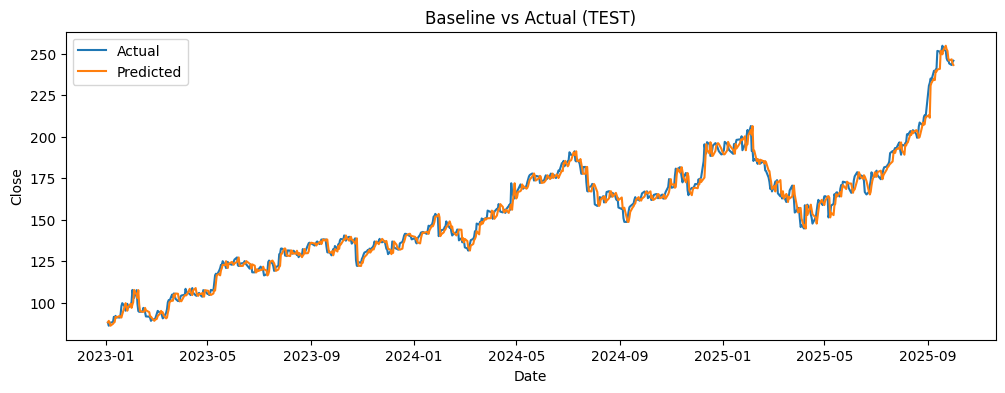

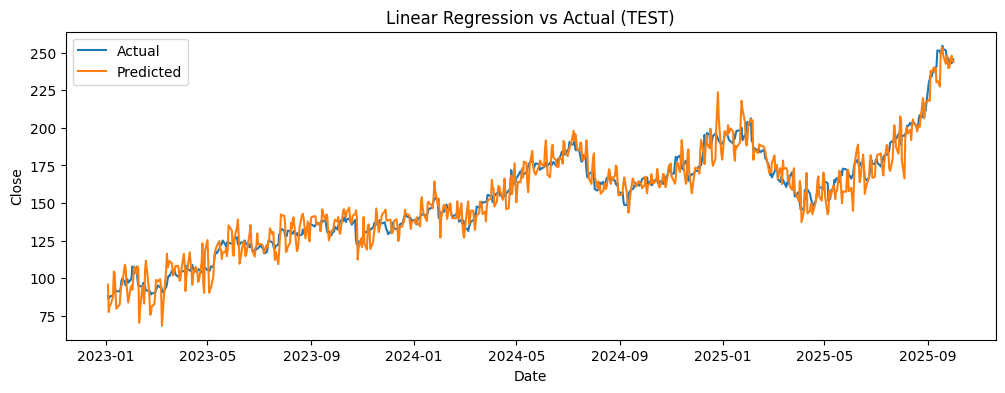

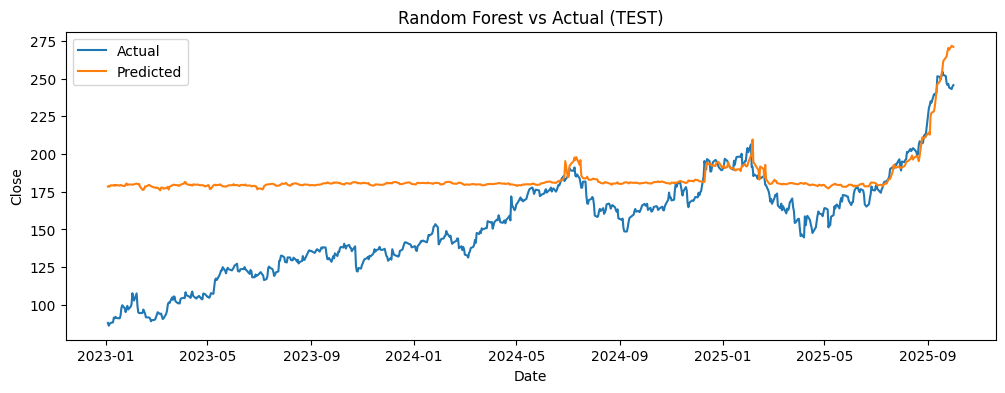

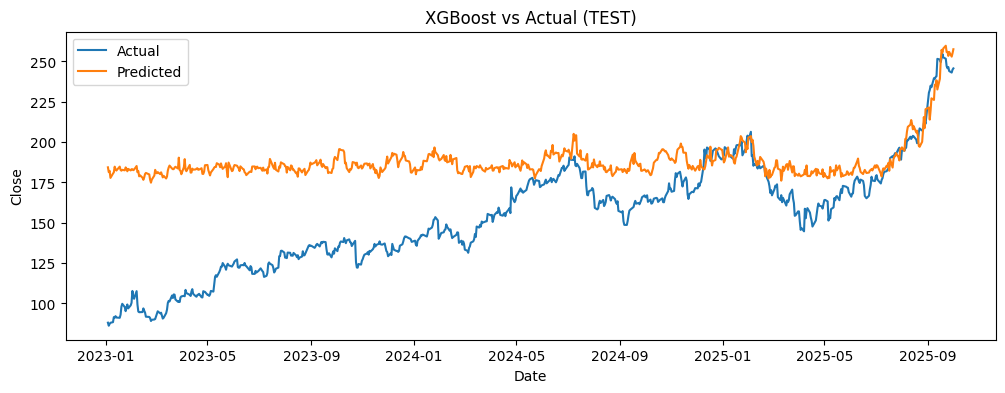

In [18]:
def plot_pred(actual, pred, dates, title):
    plt.figure(figsize=(12,4))
    plt.plot(dates, actual, label='Actual')
    plt.plot(dates, pred,   label='Predicted')
    plt.title(title); plt.xlabel('Date'); plt.ylabel('Close')
    plt.legend(); plt.show()

test_dates = pd.to_datetime(pd.Series(X_dates[test_mask]))

plot_pred(y_test, baseline_test, test_dates, "Baseline vs Actual (TEST)")
plot_pred(y_test, lin_test_pred,  test_dates, "Linear Regression vs Actual (TEST)")
plot_pred(y_test, rf_test_pred,   test_dates, "Random Forest vs Actual (TEST)")
plot_pred(y_test, xgb_test_pred,  test_dates, "XGBoost vs Actual (TEST)")


10. These charts let you see whether predictions of 3 models follow real prices over time.

In [19]:
tscv = TimeSeriesSplit(n_splits=5)
rf_maes = []

for fold, (tr_idx, va_idx) in enumerate(tscv.split(X)):
    model = RandomForestRegressor(n_estimators=300, random_state=fold, n_jobs=-1)
    model.fit(X[tr_idx], y[tr_idx])
    pred = model.predict(X[va_idx])
    mae = mean_absolute_error(y[va_idx], pred)
    rf_maes.append(mae)
    print(f"Fold {fold+1}: MAE={mae:.3f}")

print("Average MAE across folds:", np.mean(rf_maes))


Fold 1: MAE=14.012
Fold 2: MAE=106.400
Fold 3: MAE=34.387
Fold 4: MAE=558.483
Fold 5: MAE=53.806
Average MAE across folds: 153.41767423709612


11. Walk-forward CV : We repeat train→validate across multiple time splits. This checks that the model works reasonably well in different periods, not just one.

In [24]:
def metrics_table_row(name, yv_true, yv_pred, yt_true, yt_pred):
    v_mae  = mean_absolute_error(yv_true, yv_pred)
    v_rmse = math.sqrt(mean_squared_error(yv_true, yv_pred))
    v_mape = float(np.mean(np.abs((yv_true - yv_pred)/yv_true))*100)

    t_mae  = mean_absolute_error(yt_true, yt_pred)
    t_rmse = math.sqrt(mean_squared_error(yt_true, yt_pred))
    t_mape = float(np.mean(np.abs((yt_true - yt_pred)/yt_true))*100)

    return [name, v_mae, v_rmse, v_mape, t_mae, t_rmse, t_mape]

rows = []
rows.append(metrics_table_row("Baseline",        y_val, baseline_val, y_test, baseline_test))
rows.append(metrics_table_row("LinearRegression",y_val, lin_val_pred, y_test, lin_test_pred))
rows.append(metrics_table_row("RandomForest",    y_val, rf_val_pred,  y_test, rf_test_pred))
rows.append(metrics_table_row("XGBoost",         y_val, xgb_val_pred, y_test, xgb_test_pred))

summary = pd.DataFrame(rows, columns=[
    "Model","VAL_MAE","VAL_RMSE","VAL_MAPE(%)","TEST_MAE","TEST_RMSE","TEST_MAPE(%)"
])
summary


,Model,VAL_MAE,VAL_RMSE,VAL_MAPE(%),TEST_MAE,TEST_RMSE,TEST_MAPE(%)
0,Baseline,40.935767,119.982207,7.129380,3.102017,4.178642,2.045522
1,LinearRegression,50.858332,128.432348,12.248128,6.340484,8.163363,4.399270
2,RandomForest,659.025702,863.976460,42.728527,31.588639,40.675378,25.619986
3,XGBoost,674.439786,877.589373,44.064863,35.328797,44.018682,28.274778


12. This creates a neat table comparing models on validation and test sets.